In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
from PIL import Image

import torchvision.datasets as dset
import torchvision.transforms as T
import chest_xray_code.data.xrays as preprocess_dataset
import chest_xray_code.data.raw_reports as utils
import os
import torch.nn.functional as F
from models.TestConvNet import TestConvNet 
from loaders.BloodCellLoader import BloodCellLoader



import numpy as np

In [2]:
trainset = BloodCellLoader(
    root='blood_cells_data/dataset-master/JPEGImages',
    preload=False, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=24)

# load the testset
# testset = Data_SET(
#     root='chest_xray_code/data/xrays',
#     preload=True, transform=transforms.ToTensor(),
# )
#testset = trainset
# Use the torch dataloader to iterate through the dataset
#testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

print(len(trainset))

366


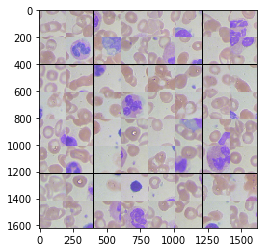

In [3]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img)
    plt.gca().axis('off')
    
    # functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))


In [6]:
NUM_TRAIN = 100

transform = T.Compose([
                T.ToTensor()
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

loader_train = trainset
images = {}

In [7]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    #dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 5

print('using device:', device)

using device: cuda


In [8]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

# Architecture and Training

In [9]:
def train(model, epoch, log_interval=100):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    model = torch.nn.DataParallel(model)
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data) in enumerate(trainset_loader):
            data = data.to(device=device, dtype=dtype)
            optimizer.zero_grad()
            #print(data.shape)
            reconstruction = model(data)
            loss_function = nn.MSELoss(size_average=True)
            loss = loss_function(reconstruction, data)
            loss.backward()
            optimizer.step()
        if ep % print_every == 0:
            print('Iteration %d, loss = %.4f' % (ep, loss.item()))
            print()

def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in testset_loader:
            data = data.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

def save_compressed(self,input,output):
    #for i in range(1):
    img = output.cpu().detach()
    for i in range(img.shape[0]):

        individual_img = img[i]
        axarr[i,1].axis('off')
        axarr[i,1].imshow(prep(individual_img))
        images[1].append(prep(individual_img))
    

In [ ]:
channels = 3
size = 32
model = OriginalConvNet(channels,size,device)
hook = model.conv_compress_final.register_forward_hook(save_compressed)
hook.remove()

optimizer = optim.Adam(model.parameters(), lr=5e-3) 
train(model,20)
#torch.save(model, 'something_else.pt')

In [ ]:
class save_output(nn.Module):
    def forward(self, x):
       
        with torch.no_grad():
            img = x.cpu().detach()
            imshow_noax(torchvision.utils.make_grid(img))
        return x

"""
plt.close("all")
f,axarr = plt.subplots(20, 2,figsize=(400,400))

f.tight_layout()
f.subplots_adjust(left=0, bottom=0, right=.1, top=.1, wspace=0, hspace=.1)

images = [[],[]]

def prep(img):
    img = img.numpy()
    if True:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    return np.transpose(img, (1, 2, 0))
    
def save_compressed(self,input,output):
    #for i in range(1):
    img = output.cpu().detach()
    for i in range(img.shape[0]):

        individual_img = img[i]
        axarr[i,1].axis('off')
        axarr[i,1].imshow(prep(individual_img))
        images[1].append(prep(individual_img))
    
    
        
        

def save_original(data):
    img = data.cpu().detach()
    
    for i in range(img.shape[0]):
        individual_img = img[i]
        individual_img = individual_img.numpy()
        individual_img = np.transpose(individual_img, (1, 2, 0))
        axarr[i,0].axis('off')
        axarr[i,0].imshow(individual_img)
        images[0].append(individual_img)



model = torch.load('blood_200_1000.pt')

model.conv_compress_final.register_forward_hook(save_compressed)
i = 0
reconstruction = None
for data in trainset_loader:
    with torch.no_grad():
        if i > 0: break
        data = data.to(device)
        display_original(data)
        reconstruction = model(data)
        i+=1
"""
for i in range(20):
    plt.figure()
    org = images[0][i]
    plt.subplot(1, 2, 1)
    plt.axis('off')
    #imshow_noax(org, normalize=False)
    plt.imshow(org)
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    rec = images[1][i]
    plt.imshow(rec)
    #imshow_noax(rec, normalize=False)
    plt.title('Compressed Image')
    plt.axis('off')
    image_str = str(i) + ".png"
    plt.savefig(image_str)
    plt.show()



In [ ]:


for i in range(20):
    plt.figure()
    org = originals[i].cpu().detach().numpy().transpose(1,2,0)
    plt.subplot(1, 2, 1)
    imshow_noax(org, normalize=False)
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    rec = reconstruction[i].cpu().detach().numpy().transpose(1,2,0)
    imshow_noax(rec, normalize=False)
    plt.title('Reconstructed image')
    plt.show()

